# Code Embedding

Now that you have learned a little about the theory behind word embedding it is time you practice it. We'll also take this opportunity to teachyou how you can work with text data in tensorflow!

## What will you learn in this course? 🧐🧐

This course is a code demonstration that will walk you through manipulating text data with tensorflow as well as train a model with an embedding layer and try interpret the results of the word embedding thanks to a dedicated tool!

In [ ]:
# Début du chrono : Lancement du script
# Durée d'exécution du notebook : 3mn48

from datetime import datetime
start = datetime.now()
print(f"Lancement de l'algorithme : {start}")

Lancement de l'algorithme : 2023-08-10 22:07:12.208465


In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Load and format the dataset

We are using the `tf.keras.utils.get_file` method in order to load the data files.

In [ ]:
df = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv', encoding="ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.describe(include='all')

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [ ]:
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We have imported data corresponding to film critiques organized in two categories: positive or negative. We'll split this data in a train set and validation set thanks to the function `tf.keras.preprocessing.text_dataset_from_directory`.

In [ ]:
# We start by downloading spacy for the english language
!python -m spacy download en_core_web_sm -q

2023-08-10 22:07:35.539864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# We can load en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# Remove all non alphanumeric characters except whitespaces
df["v2_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
df["v2_clean"] = df["v2_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
df["v2_clean"] = df["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
df.head()

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="divers",) # instanciate the tokenizer
# num_words indicates the number of words to keep in the tokenization
# keeps only the most common words

tokenizer.fit_on_texts(df.v2_clean) # fit the tokenizer on the texts
# in this step the tokenizer will list all unique tokens in the text
# and associate them with a specific integer.

# This step will effectively transform the texts into sequences of indices
df["v2_encoded"] = tokenizer.texts_to_sequences(df.v2_clean)
df

,v1,v2,v2_clean,v2_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 230, 447, 463, 942, 36, 52, 204, 943, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[10, 195, 464, 289, 2, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[13, 299, 4, 533, 664, 34, 1, 851, 423, 1, 1, ..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 150, 1, 2, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[709, 23, 665, 129]"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win å750 pound priz...,"[264, 19, 53, 4, 93, 2, 2, 34, 1, 278, 70, 4, ..."
5568,ham,Will Ì_ b going to esplanade fr home?,ì b esplanade fr home,"[46, 110, 1, 578, 27]"
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion,"[1, 937, 1, 1]"
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching act like d interested buy week free,"[113, 1, 1, 15, 33, 991, 88, 39, 13]"


In [ ]:
df_pad = tf.keras.preprocessing.sequence.pad_sequences(df.v2_encoded, padding="post")

# We'll use this to form a tensorflow dataset containing on the one hand
# the encoded texts and the labels.
df_ds = tf.data.Dataset.from_tensor_slices((df_pad, df.v1))

In [ ]:
df.v1

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelencoder= LabelEncoder()
df.v1 = labelencoder.fit_transform(df.v1)
df.v1

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: v1, Length: 5572, dtype: int64

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_pad, df.v1, test_size=0.3)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [ ]:
# We then organize the dataset per batch
train_batch = train.shuffle(len(train)).batch(64)
val_batch = train.shuffle(len(val)).batch(64)


Let's take a look at a batch of text data.

In [ ]:
for v2, v1 in train_batch.take(1):
  print(v2, v1)

tf.Tensor(
[[ 12 279 482 ...   0   0   0]
 [ 31   1   6 ...   0   0   0]
 [149 604 742 ...   0   0   0]
 ...
 [ 66 654 629 ...   0   0   0]
 [  1 237   1 ...   0   0   0]
 [395   1  11 ...   0   0   0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0], shape=(64,), dtype=int64)


The texts are in bytes format (we can see this thanks to the `b` standing right before the character strings).

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [ ]:
# Not sure it will imply better performances, given the dataset of 5572 lines
AUTOTUNE = tf.data.AUTOTUNE

train_batch = train_batch.prefetch(buffer_size=AUTOTUNE)
val_batch = val_batch.prefetch(buffer_size=AUTOTUNE)

### Modeling



In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

embedding_dim=128 # the dimensionality of the representation space

vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=[v2.shape[1],], name="embedding"),
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 128)           128000    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 130,081
Trainable params: 130,081
Non-trainable params: 0
_________________________________________________________________


Now that we have built the vectorization layer, we are ready to build the model. I build a very simple **binary** classification model.

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=200,
    callbacks=[tensorboard_callback])

Epoch 1/200
61/61 [==============================] - 2s 11ms/step - loss: 0.5491 - accuracy: 0.8544 - val_loss: 0.3972 - val_accuracy: 0.8651
Epoch 2/200
61/61 [==============================] - 1s 12ms/step - loss: 0.3579 - accuracy: 0.8651 - val_loss: 0.3383 - val_accuracy: 0.8651
Epoch 3/200
61/61 [==============================] - 1s 16ms/step - loss: 0.3215 - accuracy: 0.8651 - val_loss: 0.2979 - val_accuracy: 0.8651
Epoch 4/200
61/61 [==============================] - 1s 8ms/step - loss: 0.2663 - accuracy: 0.8656 - val_loss: 0.2269 - val_accuracy: 0.8774
Epoch 5/200
61/61 [==============================] - 1s 8ms/step - loss: 0.1935 - accuracy: 0.9136 - val_loss: 0.1620 - val_accuracy: 0.9431
Epoch 6/200
61/61 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.9531 - val_loss: 0.1185 - val_accuracy: 0.9651
Epoch 7/200
61/61 [==============================] - 0s 7ms/step - loss: 0.1051 - accuracy: 0.9672 - val_loss: 0.0904 - val_accuracy: 0.9738
Epoch 8/20

# RESULTS

## LOSS en fonction des epochs

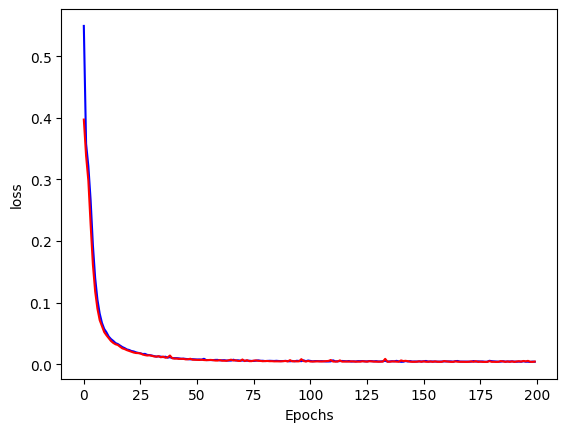

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()


## Accuracy en fonction des epochs

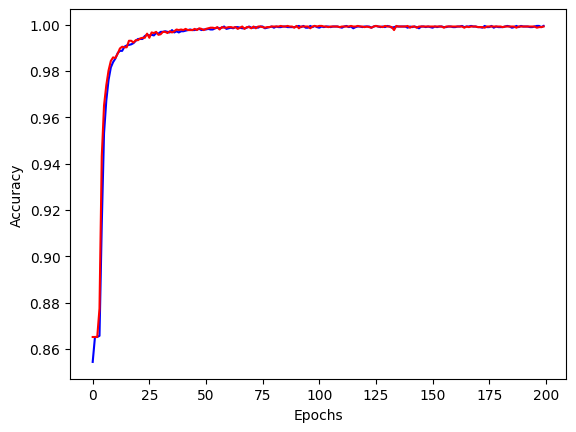

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()


# OUTPUT EMBEDDING

In [ ]:
vocab = [value for value in tokenizer.index_word.values()][:1000]
weights = model.get_layer('embedding').get_weights()[0]

log_dir = "/content/logs/embed"
os.makedirs(log_dir, exist_ok=True)
out_v = io.open(log_dir+"/vectors.tsv", 'w', encoding='utf-8')
out_m = io.open(log_dir+"/metadata.tsv", 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

Il est possible de visualiser les résultats sur le site https://projector.tensorflow.org/ avec le fichier metadata.tsv.


In [ ]:
# Fin du chrono : Fin du script
from datetime import datetime
end = datetime.now()
duree = end - start
print(f'Durée du script : {duree}')

Durée du script : 0:03:56.545549
